##### Import library

In [80]:
import kaos
import seaborn as sns
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import requests
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

In [67]:
def custom_figure_axis(ax, fontsize=10, show_ticks = True):

    """
    Customize the appearance of matplotlib axis for a figure.

    Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The axis to be customized.
        fontsize (int, optional): Font size for axis labels and ticks. Default is 10.
        show_ticks (bool, optional): Whether to display ticks and labels. Default is True.

    Returns:
        matplotlib.axes._subplots.AxesSubplot: The customized axis.
    """

    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.2)
    ax.spines['left'].set_linewidth(0.2)
    ax.tick_params(axis='x', labelsize=fontsize, rotation=90)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.tick_params(axis='both', which='both', width=0.5)
    ax.xaxis.label.set_fontsize(fontsize)
    ax.yaxis.label.set_fontsize(fontsize)
    
    if show_ticks==False:
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
    return ax

##### Define kmer length

In [2]:
kmer_length = 4

##### Read DNA sequence

In [3]:
SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'
sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.
# sequences

##### Read corresponding label

In [5]:
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

##### One hot encode the labels

In [6]:
one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

##### Divide the data in X, y

In [8]:
X = list()

for i in range(len(sequences)):
    X.append(kaos.kaos_fcgr().chaos_frequency_matrix(sequences[i], kmer_length= kmer_length)[0])

y = input_labels.copy()

##### Divide the data in train (80%) and test (20%)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size=0.2, random_state=42)

##### Define model architecture

In [52]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(filters=16, kernel_size=3))
# model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 14, 16)            784       
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 3, 16)            0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 1, 16)             784       
                                                                 
 flatten_8 (Flatten)         (None, 16)                0         
                                                                 
 dense_16 (Dense)            (None, 16)                272       
                                                                 
 dense_17 (Dense)            (None, 2)                 34        
                                                     

##### Train the model

In [53]:
history = model.fit(X_train, y_train, epochs=100, verbose=1, validation_split=0.2, batch_size=1024)

Epoch 1/100
2/2 [==============================] - 1s 346ms/step - loss: 0.7754 - accuracy: 0.4586 - precision: 0.4586 - recall: 0.4586 - val_loss: 0.7268 - val_accuracy: 0.5344 - val_precision: 0.5344 - val_recall: 0.5344
Epoch 2/100
2/2 [==============================] - 0s 84ms/step - loss: 0.7449 - accuracy: 0.4852 - precision: 0.4852 - recall: 0.4852 - val_loss: 0.7112 - val_accuracy: 0.5406 - val_precision: 0.5406 - val_recall: 0.5406
Epoch 3/100
2/2 [==============================] - 0s 110ms/step - loss: 0.7260 - accuracy: 0.5164 - precision: 0.5164 - recall: 0.5164 - val_loss: 0.6779 - val_accuracy: 0.5781 - val_precision: 0.5781 - val_recall: 0.5781
Epoch 4/100
2/2 [==============================] - 0s 116ms/step - loss: 0.6845 - accuracy: 0.5656 - precision: 0.5656 - recall: 0.5656 - val_loss: 0.6645 - val_accuracy: 0.5938 - val_precision: 0.5938 - val_recall: 0.5938
Epoch 5/100
2/2 [==============================] - 0s 101ms/step - loss: 0.6678 - accuracy: 0.5891 - precisio

##### Plot all the required curve

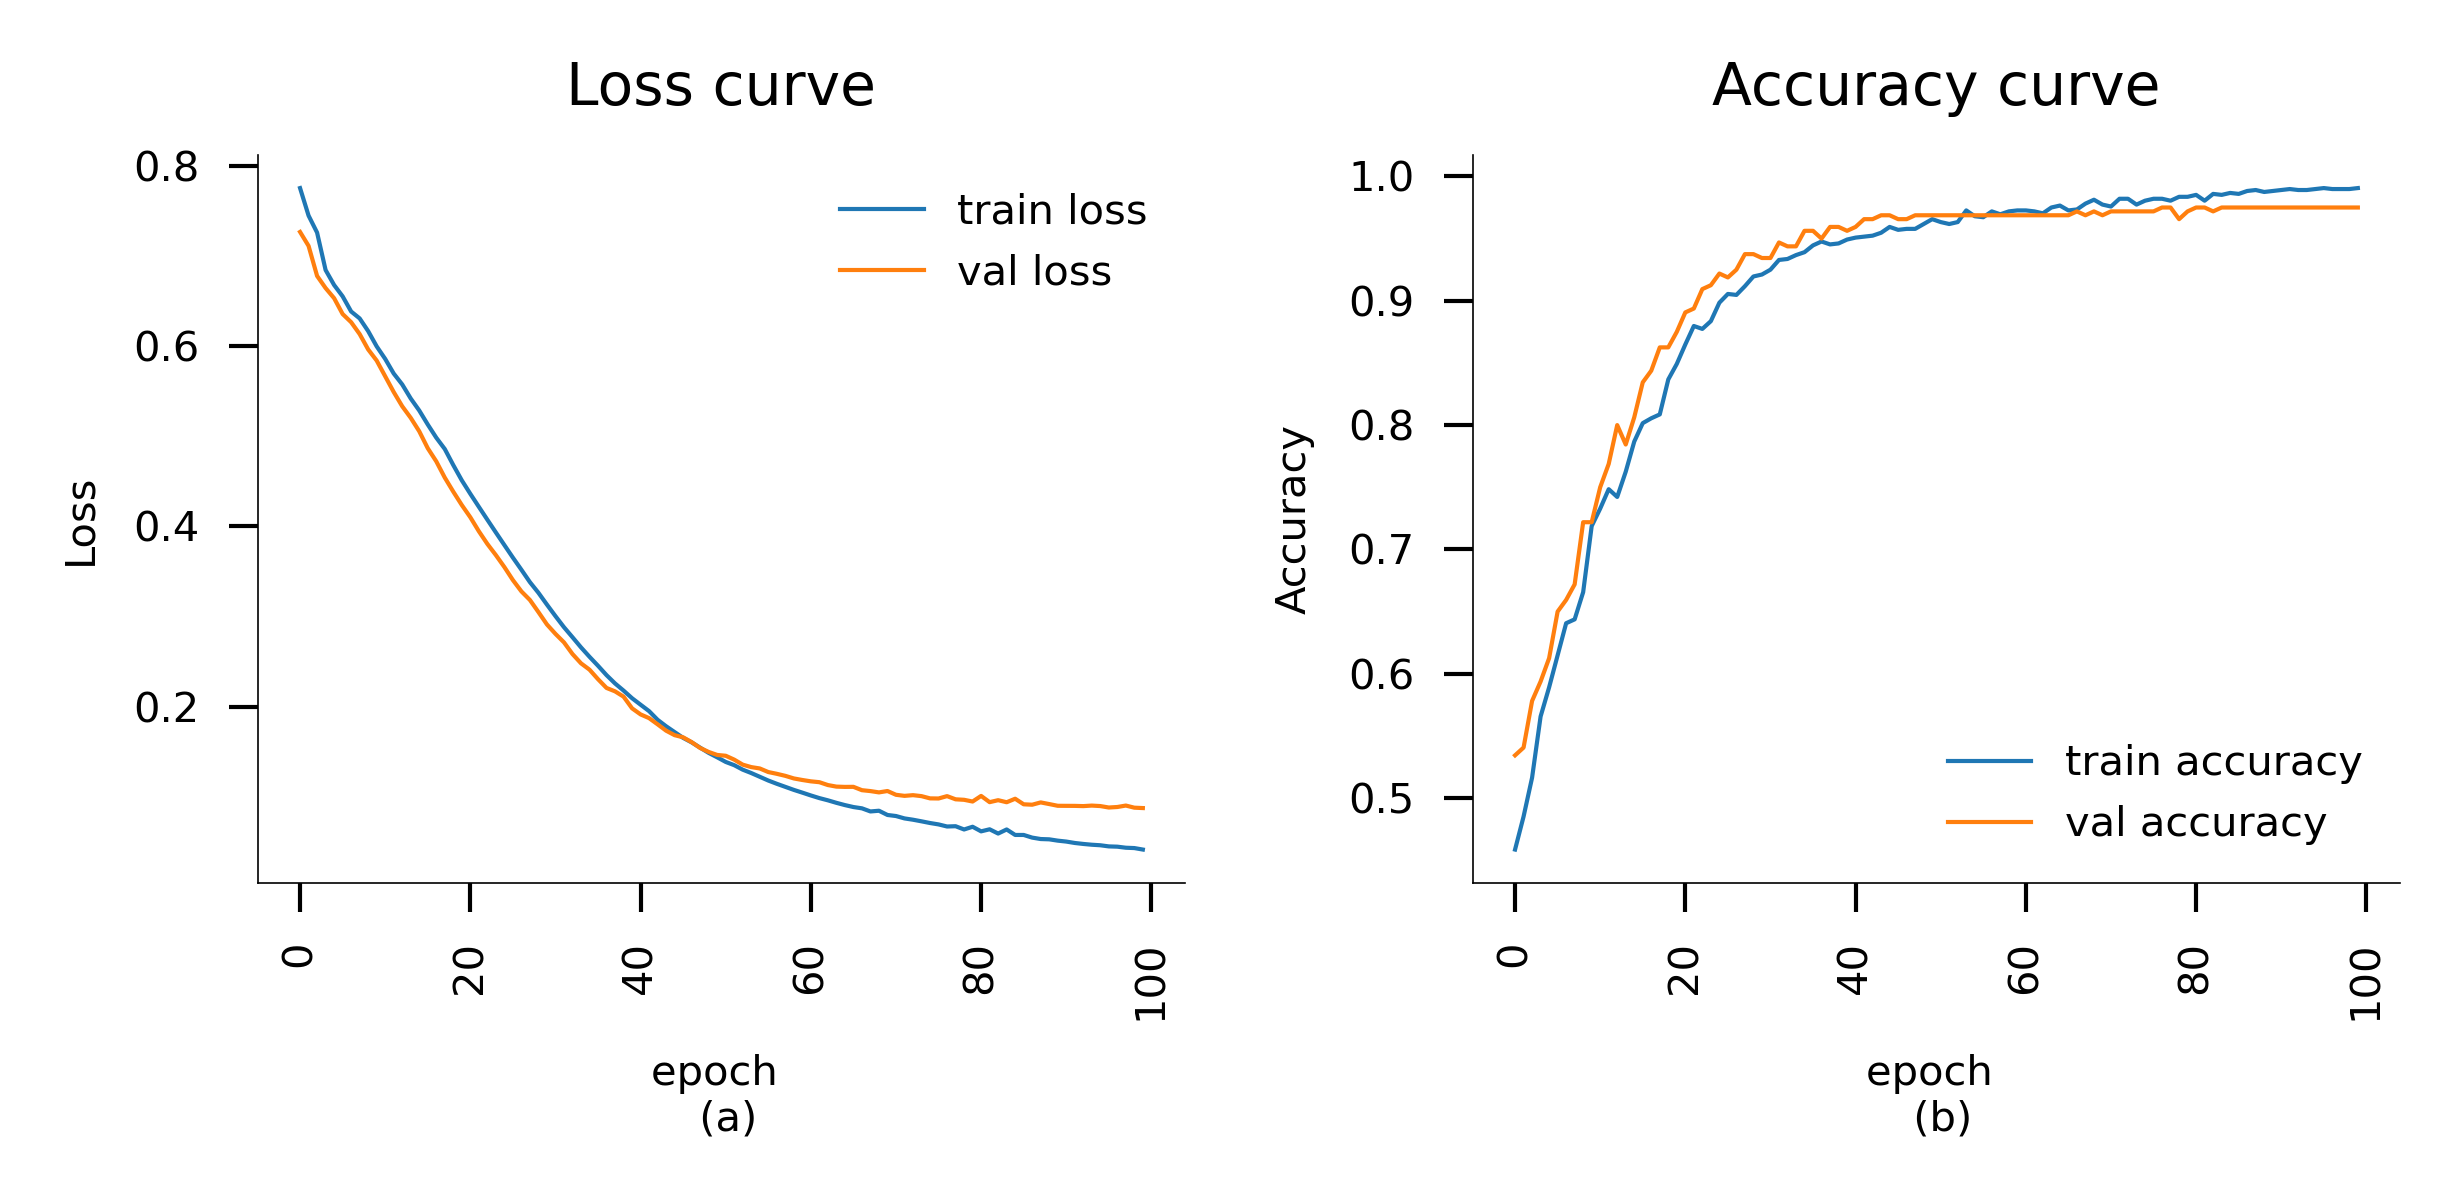

In [75]:
fig, ax= plt.subplots(1, 2, dpi =600, figsize = (4.2,2.1))
ax[0].plot(history.history['loss'], label = "train loss", lw = 0.5)
ax[0].plot(history.history['val_loss'], label = "val loss", lw = 0.5)
ax[1].plot(history.history['accuracy'], label = "train accuracy", lw = 0.5)
ax[1].plot(history.history['val_accuracy'], label = "val accuracy", lw = 0.5)
ax[0].legend(fontsize=5, frameon=False)
ax[1].legend(fontsize=5, frameon=False)
ax[0].set_title("Loss curve", fontsize=7)
ax[1].set_title("Accuracy curve", fontsize=7)
ax[0].set_xlabel("epoch \n (a)", fontsize=5)
ax[1].set_xlabel("epoch \n (b)", fontsize=5)
ax[0].set_ylabel("Loss", fontsize=5)
ax[1].set_ylabel("Accuracy", fontsize=5)
ax[0].tick_params(axis='both', which='major', labelsize=5)
ax[1].tick_params(axis='both', which='major', labelsize=5)
ax[0] = custom_figure_axis(ax[0], fontsize=5, show_ticks = True)
ax[1] = custom_figure_axis(ax[1], fontsize=5, show_ticks = True)
plt.tight_layout()

In [98]:
# pickle.dump(model, open('motif discovery model.pickle', 'wb'))

##### Plot confusion matrix for test set

13/13 [==============================] - 0s 2ms/step


Confusion matrix:
 [[201   4]
 [  0 195]]


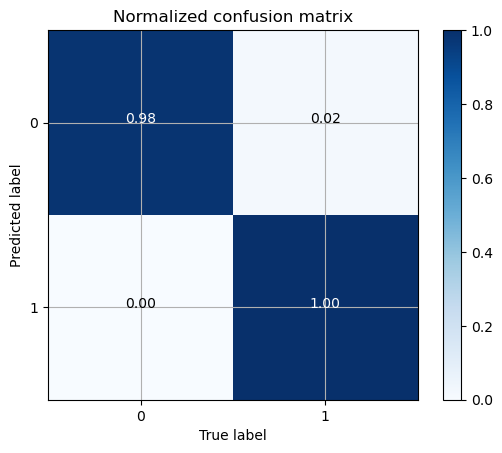

In [93]:
predicted_labels = model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] >= 0.5 else 'black')

In [89]:
print("The accuracy of test set is ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(predicted_labels, axis=1)))
print("The precision of test set is ",  precision_score(np.argmax(y_test, axis=1), np.argmax(predicted_labels, axis=1)))
print("The recall of test set is ", recall_score(np.argmax(y_test, axis=1), np.argmax(predicted_labels, axis=1)))
print("The f1 of test set is ",  f1_score(np.argmax(y_test, axis=1), np.argmax(predicted_labels, axis=1)))
print("The ROC_AUC of test set is ", roc_auc_score(np.argmax(y_test, axis=1), np.argmax(predicted_labels, axis=1)))
print("The cohen kappa of test set is ", cohen_kappa_score(np.argmax(y_test, axis=1), np.argmax(predicted_labels, axis=1)))


The accuracy of test set is  0.99
The precision of test set is  0.9798994974874372
The recall of test set is  1.0
The f1 of test set is  0.9898477157360407
The ROC_AUC of test set is  0.9902439024390244
The cohen kappa of test set is  0.979997499687461
